In [2]:
from __future__ import division
import MySQLdb
import MySQLdb.cursors
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as LinR
import numpy as np
import sys
import re
import matplotlib as plt
from sklearn.decomposition import PCA
import scipy as sp



def get_fanduel(predict,avg,tru):
    fanduel_pre = predict[0]+predict[2]*1.2+predict[3]*1.5+predict[4]*2+predict[5]*2-predict[6]
    fanduel_avg = avg[0]+avg[2]*1.2+avg[3]*1.5+avg[4]*2+avg[5]*2-avg[6]
    fanduel_tru = tru[0]+tru[2]*1.2+tru[3]*1.5+tru[4]*2+tru[5]*2-tru[6]
    return fanduel_pre, fanduel_avg, fanduel_tru



def get_trend(fan_pre,fan_avg,fan_tru):
    
    if (fan_pre > fan_avg) and (fan_tru > fan_avg):
        val = 1
    elif (fan_pre < fan_avg) and (fan_tru < fan_avg):
        val = 1
    elif (fan_pre < fan_avg) and (fan_tru > fan_avg):
        val = 0
    elif (fan_pre > fan_avg) and (fan_tru < fan_avg):    
        val = 0
    else:
        val = 2
    return val



conn = MySQLdb.connect(
            user="root",
            passwd="",
            db="Player_Team_Data",
            cursorclass=MySQLdb.cursors.DictCursor)


# In[97]:
# read in AllPlayerNames .csv from basketball-reference
df_all_players = pd.read_csv('~/Insight/Players100.csv')
    # Remove rows that were separated by random 'Player' entries
df_all_players = df_all_players[df_all_players.Name != 'Player']

name_list=list(df_all_players.values)
new_name_list = []

for name in name_list:
        # convert entries to strings
    name = str(name)
    new_name_list.append(name)

unique_name_list=list(set(new_name_list))
unique_name_list.sort()
name_list_final = []
for name in unique_name_list:
    match = re.search('([\w\.\-\']+) ([\w\.\-]+)', name)
    prename = match.group(1).lower()[1:] + ' ' + match.group(2).lower()
    name_list_final.append(prename)

name_list_fin = [x for x in name_list_final if x != 'george hill']

validation={}

for player in name_list_fin:
    print player
    cmd_Rk= 'SELECT Rk FROM NBA_player_data WHERE Player_Name IN (\'' + player + '\')  AND Year IN (\'2015\');'
    df_Rk = pd.read_sql(cmd_Rk, con=conn) 

    f_pre = []
    f_avg = []
    f_tru = []
    prediction_list = []
    average_list = []
    true_list = []

    for Rki in df_Rk.Rk:
        Rk = str(Rki)
        cmd_target_2015 = 'SELECT PTS,3P,TRB,AST,STL,BLK,TOV FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk < '+Rk+' ;'
        cmd_target_2014 = 'SELECT PTS,3P,TRB,AST,STL,BLK,TOV FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2014\') AND Rk >= '+Rk+' ;'
        cmd_train_2015 = 'SELECT MP,Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk < '+Rk+';'
        cmd_train_2014 = 'SELECT MP,Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2014\') AND Rk >= '+Rk+';'
        cmd_operate = 'SELECT Rk,Home_Away,DateDiff,TeamID,Win,OPPG,OTPR,O3Ppercent,ORPG,OBPG,OSPG,DEF,O3PM,OFGpercent,OTPG,OAPG,TPG,SPG,TRBR,OBLKpercent FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk = '+Rk+';'
        cmd_truth = 'SELECT PTS,3P,TRB,AST,STL,BLK,TOV FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk = '+Rk+' ;'
        cmd_min_2015 = 'SELECT MP FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk < '+Rk+';'   
        cmd_min_2014 = 'SELECT MP FROM NBA_player_data_MP WHERE Player_Name IN (\'' + player + '\') AND Year IN (\'2015\') AND Rk >= '+Rk+';'   
    
        df_min_2015 = pd.read_sql(cmd_min_2015, con=conn) 
        df_min_2014 = pd.read_sql(cmd_min_2014, con=conn) 
        df_target_2015 = pd.read_sql(cmd_target_2015, con=conn) 
        df_target_2014 = pd.read_sql(cmd_target_2014, con=conn) 
        df_train_2015 = pd.read_sql(cmd_train_2015, con=conn) 
        df_train_2014 = pd.read_sql(cmd_train_2014, con=conn) 
        df_operate = pd.read_sql(cmd_operate, con=conn) 
        df_truth = pd.read_sql(cmd_truth, con=conn) 
        df_truth = df_truth.applymap(lambda x: float(x))
        
        df_min = pd.concat([df_min_2014, df_min_2015],ignore_index=True).applymap(lambda x: float(x))
        mean_MP = df_min.mean().values[0]
        
        df_operate['MP'] = mean_MP
        
        df_target=pd.concat([df_target_2014, df_target_2015],ignore_index=True)
        df_train=pd.concat([df_train_2014, df_train_2015],ignore_index=True)
        df_target = df_target.applymap(lambda x:float(x))
        df_train = df_train.applymap(lambda x:float(x))
        df_target_2015 = df_target_2015.applymap(lambda x: float(x))

        df_inquire = df_operate.applymap(lambda x:float(x))
        df_train_plus_inquire=pd.concat([df_train, df_inquire])
        df_raw = df_train_plus_inquire.reindex()
        df_raw_scaled = df_raw.copy()
        df_raw_scaled = df_raw_scaled.applymap(lambda x: np.log(x))
        df_raw_transform = df_raw.copy()
        

        df_raw_scaled = df_raw_scaled.apply(lambda x:preprocessing.StandardScaler().fit(x).transform(x))
        df_raw_transform = df_raw_transform.apply(lambda x:preprocessing.StandardScaler().fit(x))

#         pca = PCA()
#         pca.fit(df_raw_scaled)
#         pca.n_components=7
#         train_reduced = pca.fit_transform(df_raw_scaled)
#         df_train_reduced=pd.DataFrame(train_reduced)
        df_evaluate = df_raw_scaled.tail(1)
        df_train_scaled = df_raw_scaled.iloc[:-1]


        # rf = RandomForestRegressor(n_estimators=100)
        # rf.fit(df_train_scaled, df_target)
        # predictions = rf.predict(df_evaluate).round()[0]

        PTS = LinR()
        PTS.fit(df_train_scaled, df_target.PTS)
        pPTS = PTS.predict(df_evaluate)
        REB = LinR()
        REB.fit(df_train_scaled, df_target.TRB)
        pREB = REB.predict(df_evaluate)
        AST = LinR()
        AST.fit(df_train_scaled, df_target.AST)
        pAST = AST.predict(df_evaluate)
        TP = LinR()
        TP.fit(df_train_scaled, df_target['3P'])
        pTP = TP.predict(df_evaluate)
        STL = LinR()
        STL.fit(df_train_scaled, df_target.STL)
        pSTL = STL.predict(df_evaluate)
        BLK = LinR()
        BLK.fit(df_train_scaled, df_target.BLK)
        pBLK = BLK.predict(df_evaluate)
        TOV = LinR()
        TOV.fit(df_train_scaled, df_target.TOV)
        pTOV = TOV.predict(df_evaluate)

        predictions = np.asarray([pPTS,pTP,pREB,pAST,pSTL,pBLK,pTOV])

        if int(Rk) < 20:
            average_stats=df_target.mean()
            #average_stats=df_target.mean().round()   
        elif int(Rk) >= 20:
            #average_stats=df_target_2015.mean().round()
            average_stats=df_target_2015.mean()
        average_stats=np.asarray(average_stats)
        true_stats = np.asarray(df_truth)[0]
        fanduel_pre, fanduel_avg, fanduel_tru = get_fanduel(predictions,average_stats,true_stats)
        f_pre.append(fanduel_pre)
        f_avg.append(fanduel_avg)
        f_tru.append(fanduel_tru)
        prediction_list.append(predictions)
        average_list.append(average_stats)
        true_list.append(true_stats)

    score =[]
    for i,f in enumerate(f_pre):
        s=get_trend(f,f_avg[i],f_tru[i])
        score.append(s)

    ats = [x for x in score if x != 2]
    pts =[]
    reb = []
    ast = []
    tp = []
    stl =[]
    blk =[]
    to =[]


    for i,pred in enumerate(prediction_list):
        p=get_trend(float(prediction_list[i][0]),float(average_list[i][0]),float(true_list[i][0]))
        r=get_trend(float(prediction_list[i][2]),float(average_list[i][2]),float(true_list[i][2]))
        a=get_trend(float(prediction_list[i][3]),float(average_list[i][3]),float(true_list[i][3]))
        tpm=get_trend(float(prediction_list[i][1]),float(average_list[i][1]),float(true_list[i][1]))
        s=get_trend(float(prediction_list[i][4]),float(average_list[i][4]),float(true_list[i][4]))
        b=get_trend(float(prediction_list[i][5]),float(average_list[i][5]),float(true_list[i][5]))
        t=get_trend(float(prediction_list[i][6]),float(average_list[i][6]),float(true_list[i][6]))

        pts.append(p)
        reb.append(r)
        ast.append(a)
        tp.append(tpm)
        stl.append(s)
        blk.append(b)
        to.append(t)

    pts = [x for x in pts if x != 2]
    reb = [x for x in reb if x != 2]
    ast = [x for x in ast if x != 2]
    tp = [x for x in tp if x != 2]
    stl = [x for x in stl if x != 2]
    blk = [x for x in blk if x != 2]
    to = [x for x in to if x != 2]


    f_accuracy = round(100*(ats.count(1)/len(ats)),2)
    if len(pts) > 0:
        pts_accuracy = round(100*(pts.count(1)/len(pts)),2)
    else: 
        pts_accuracy =np.nan
    if len(reb) > 0:    
        reb_accuracy = round(100*(reb.count(1)/len(reb)),2)
    else:
        reb_accuracy =np.nan
    if len(ast) > 0:
        ast_accuracy = round(100*(ast.count(1)/len(ast)),2)
    else:
        ast_accuracy =np.nan
    if len(tp) > 0:
        tp_accuracy = round(100*(tp.count(1)/len(tp)),2)
    else:
        tp_accuracy =np.nan
    if len(stl) > 0:
        stl_accuracy = round(100*(stl.count(1)/len(stl)),2)
    else:
        stl_accuracy =np.nan
    if len(blk) > 0:
        blk_accuracy = round(100*(blk.count(1)/len(blk)),2)
    else:
        blk_accuracy =np.nan
    if len(to) > 0:
        to_accuracy = round(100*(to.count(1)/len(to)),2)
    else:
        to_accuracy =np.nan
    val_values=[f_accuracy, pts_accuracy,tp_accuracy,reb_accuracy,ast_accuracy,stl_accuracy,blk_accuracy,to_accuracy]  

    validation[player] = val_values
df_validation = pd.DataFrame(validation, index = ['Fanduel','Points','TPM','Rebounds','Assists','Steals','Blocks','TO'])

al horford
al jefferson
amir johnson
andre drummond
anthony davis
arron afflalo
avery bradley
ben mclemore
blake griffin
bradley beal
brandon bass
brandon knight
brook lopez
carlos boozer
carmelo anthony
chris bosh
chris paul
corey brewer
courtney lee
damian lillard
danny green
david west
deandre jordan
demarcus cousins
demarre carroll
demar derozan
deron williams
derrick favors
dion waiters
dirk nowitzki
draymond green
dwyane wade
enes kanter
eric bledsoe
gerald green
gerald henderson
giannis antetokounmpo
goran dragic
gordon hayward
gorgui dieng
harrison barnes
isaiah thomas
jamal crawford
james harden
jarrett jack
jeff green
jeff teague
jeremy lin
jimmy butler
joe johnson
john wall
jonas valanciunas
jordan hill
josh smith
kawhi leonard
kenneth faried
kentavious caldwell-pope
kevin durant
kevin love
khris middleton
klay thompson
kyle korver
kyle lowry
kyrie irving
lamarcus aldridge
lebron james
louis williams
luol deng
manu ginobili
marc gasol
marcin gortat
mario chalmers
markieff mo

In [3]:
df_validation.T.Blocks.mean()

51.149393939393946

In [4]:
df_validation

,al horford,al jefferson,amir johnson,andre drummond,anthony davis,arron afflalo,avery bradley,ben mclemore,blake griffin,bradley beal,...,tim duncan,tony parker,trevor ariza,trey burke,ty lawson,tyreke evans,tyson chandler,victor oladipo,wilson chandler,zach randolph
Fanduel,46.05,53.85,41.33,54.88,57.35,53.85,55.84,50.00,68.66,42.86,...,49.35,45.59,59.76,48.68,48.00,56.96,61.33,56.94,47.44,57.75
Points,51.32,43.08,50.67,54.88,44.12,48.72,59.74,54.88,56.72,47.62,...,57.14,36.76,50.00,51.32,48.00,50.63,54.67,56.94,58.97,49.30
TPM,46.05,60.98,46.67,NaN,51.16,51.28,49.35,46.34,49.25,52.38,...,39.29,50.00,54.88,51.32,42.47,46.84,NaN,52.86,52.00,49.30
Rebounds,53.95,53.85,45.33,56.10,48.53,55.13,45.45,54.88,44.78,49.21,...,49.35,51.47,51.22,43.42,52.70,56.96,50.67,40.28,51.95,52.11
Assists,55.26,64.62,52.00,51.22,54.41,52.56,51.95,51.85,58.21,47.54,...,44.16,44.78,57.32,46.05,50.67,64.56,46.67,59.72,46.15,59.15
Steals,48.68,53.85,48.00,43.75,66.18,56.41,51.32,56.10,59.70,55.56,...,48.68,51.47,58.02,43.42,46.67,48.10,50.67,50.00,53.85,39.44
Blocks,51.32,60.00,55.41,52.44,64.71,44.87,54.55,47.56,44.78,63.49,...,54.55,44.12,50.00,48.68,45.33,48.10,57.33,50.00,64.10,56.34
TO,51.32,49.18,46.67,42.68,51.47,47.44,45.45,42.68,55.22,44.44,...,48.65,44.12,52.44,57.89,49.32,53.25,46.67,56.94,56.41,56.34


In [5]:
df_val = df_validation.T.reindex()

In [6]:
df_val

,Fanduel,Points,TPM,Rebounds,Assists,Steals,Blocks,TO
al horford,46.05,51.32,46.05,53.95,55.26,48.68,51.32,51.32
al jefferson,53.85,43.08,60.98,53.85,64.62,53.85,60.00,49.18
amir johnson,41.33,50.67,46.67,45.33,52.00,48.00,55.41,46.67
andre drummond,54.88,54.88,NaN,56.10,51.22,43.75,52.44,42.68
anthony davis,57.35,44.12,51.16,48.53,54.41,66.18,64.71,51.47
arron afflalo,53.85,48.72,51.28,55.13,52.56,56.41,44.87,47.44
avery bradley,55.84,59.74,49.35,45.45,51.95,51.32,54.55,45.45
ben mclemore,50.00,54.88,46.34,54.88,51.85,56.10,47.56,42.68
blake griffin,68.66,56.72,49.25,44.78,58.21,59.70,44.78,55.22
bradley beal,42.86,47.62,52.38,49.21,47.54,55.56,63.49,44.44


In [7]:
df_val=df_val.reset_index()

In [8]:
df_value=df_val.rename(columns={'index': 'Player_Name','TO':'TOV'})

In [9]:
from sqlalchemy import create_engine
from sqlalchemy.types import String
df_value

,Player_Name,Fanduel,Points,TPM,Rebounds,Assists,Steals,Blocks,TOV
0,al horford,46.05,51.32,46.05,53.95,55.26,48.68,51.32,51.32
1,al jefferson,53.85,43.08,60.98,53.85,64.62,53.85,60.00,49.18
2,amir johnson,41.33,50.67,46.67,45.33,52.00,48.00,55.41,46.67
3,andre drummond,54.88,54.88,NaN,56.10,51.22,43.75,52.44,42.68
4,anthony davis,57.35,44.12,51.16,48.53,54.41,66.18,64.71,51.47
5,arron afflalo,53.85,48.72,51.28,55.13,52.56,56.41,44.87,47.44
6,avery bradley,55.84,59.74,49.35,45.45,51.95,51.32,54.55,45.45
7,ben mclemore,50.00,54.88,46.34,54.88,51.85,56.10,47.56,42.68
8,blake griffin,68.66,56.72,49.25,44.78,58.21,59.70,44.78,55.22
9,bradley beal,42.86,47.62,52.38,49.21,47.54,55.56,63.49,44.44


In [13]:
df_value.Fanduel.std()

6.5309640785649341

In [ ]:
pd.DataFrame.plot(

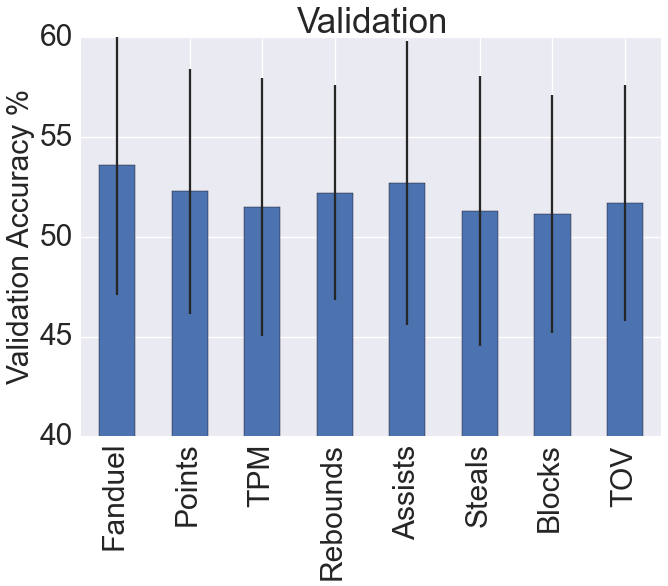

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')
df_value.mean().plot(kind='bar', yerr=df_value.std())

plt.ylabel('Validation Accuracy %',fontsize=30)
plt.title('Validation',fontsize=35) 
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.ylim((40,60))
plt.savefig('vd.png')

In [10]:
round(t,2)

1.0